In [12]:
import os

import numpy as np
from PIL import Image
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from utils import *

import tensorflow as tf

In [13]:
def stack_frames(to_be_stacked, compass):
    
    stacked_frames = deque([np.zeros((64,64), dtype=np.uint) for i in range(stack_size)], maxlen=4)
    compass_channel = np.ones(shape=list(to_be_stacked[0].shape[:-1]) + [1], dtype=to_be_stacked.dtype) * compass

    if len(to_be_stacked) != 4:
        for x in range(4-len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[0].reshape(64,64,3), "RGB").convert("L")))
        for x in range(len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[x].reshape(64,64,3), "RGB").convert("L")))
        
        stacked_frames = np.stack(stacked_frames, axis=2)
        stacked_frames = np.concatenate([stacked_frames, compass_channel], axis=-1)
    else:
        for x in range(len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[x].reshape(64,64,3), "RGB").convert("L")))
        
        stacked_frames = np.stack(stacked_frames, axis=2)
        stacked_frames = np.concatenate([stacked_frames, compass_channel], axis=-1)
    
    return stacked_frames

(array([[[[ 0.,  0.,  2.],
          [20., 24., 26.],
          [16., 20., 22.],
          ...,
          [ 5., 10.,  9.],
          [12., 18., 19.],
          [12., 18., 19.]],
 
         [[ 4.,  8., 10.],
          [20., 24., 26.],
          [20., 24., 26.],
          ...,
          [ 5., 10.,  9.],
          [12., 18., 19.],
          [12., 18., 19.]],
 
         [[ 7., 12., 11.],
          [ 9., 14., 13.],
          [ 8., 13., 12.],
          ...,
          [12., 18., 19.],
          [13., 17., 19.],
          [ 0.,  0.,  2.]],
 
         ...,
 
         [[30., 42., 48.],
          [30., 42., 48.],
          [34., 46., 54.],
          ...,
          [ 3.,  4.,  9.],
          [ 3.,  4.,  9.],
          [ 3.,  4.,  9.]],
 
         [[32., 42., 48.],
          [32., 42., 48.],
          [34., 46., 52.],
          ...,
          [ 3.,  4.,  9.],
          [ 3.,  4.,  9.],
          [ 3.,  4.,  9.]],
 
         [[31., 41., 47.],
          [31., 41., 47.],
          [26., 38., 44.],
   

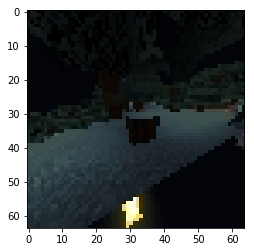

In [14]:
path = "C:\\Users\\Robin\\Desktop\\deep_learning\\MineRLNavigateDense-v0\\"

def generate_random_video(path, batch_size=1):
    frame_shape = 64*64*3
    
    videos = list(os.listdir(path))
    
    random_video_num = np.random.randint(len(videos)-4)
    rand_vid = os.path.join(path+videos[random_video_num])
    
    vid_labels = np.load(rand_vid+"\\rendered.npz", allow_pickle=True)
    vid_labels = [vid_labels[x] for x in vid_labels.keys()]
    
    rewards = np.array(vid_labels[0])
    compass_angle = np.array(vid_labels[1])/180.
    
    camera_x = np.array([x[0] for x in vid_labels[11]])/180.
    camera_y = np.array([x[1] for x in vid_labels[11]])/180.
    place = vid_labels[-1]
    vid_labels = vid_labels[:11]
    '''if camera_x.all() > 0:
        vid_labels.append(1)
    elif camera_x.all() < 0:
        vid_labels.append(0)
    
    if camera_y.all() > 0:
        vid_labels.append(1)
    elif camera_y.all() < 0:
        vid_labels.append(0)'''
    vid_labels.append(place) 
    vid_labels.append(camera_x)
    vid_labels.append(camera_y)
    vid_labels = vid_labels[3:]
    
    for i in range(len(vid_labels[-3])):
        if vid_labels[-3][i] == "none":
            vid_labels[-3][i] = 0
        else:
            vid_labels[-3][i] = 1
    
    actions = []
    
    for i in range(len(vid_labels[0])):
        action_cluster = []
        for x in range(11):
            element = vid_labels[x][i]
            if x == 9 or x == 10:
                if float(element) > 0:
                    action_cluster.append(1)
                    action_cluster.append(0)
                elif float(element) < 0:
                    action_cluster.append(0)
                    action_cluster.append(1)
                else:
                    action_cluster.append(0)
                    action_cluster.append(0)
            else:
                action_cluster.append(element)
        actions.append(action_cluster)
    
    load_vid = np.load(rand_vid+"\\NDTRAIN.npy", allow_pickle=True)[0]
    
    frames = int(load_vid.shape[0]/frame_shape)
    
    reshaped_vid = load_vid.reshape(frames, 64, 64, 3)[-len(vid_labels[0]):]
    plt.imshow(reshaped_vid[0].astype(np.uint8))
    
    return reshaped_vid, actions, compass_angle, rewards

generate_random_video(path)

In [182]:
actions = [1,1,0,0,0,0,1,0,0,1,1,0,0]
actions = np.array(actions).reshape(-1, 1)

kmeans = KMeans(n_clusters=2, random_state=0).fit(actions)
print(kmeans.cluster_centers_)

[[0.]
 [1.]]


In [172]:
actions = [1,1,0,0,0,0,1,0,0,1,1,0,0]
def action_grid(actions):
    grid = np.zeros((13, 13))
    for each in range(len(actions)):
        line = np.zeros((13))
        if actions[each] != 0:
            line[each] = 1
        grid[each] = line 
    return(grid)
        
grid = action_grid(actions)

In [164]:
def grid_to_action(grid):
    actions = []
    for each in range(grid.shape[0]):
        actions.append(grid[each][each])
    
    return np.array(actions)

print(grid_to_action(grid))

[1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.]


In [174]:
def build_model():
    dqn = keras.models.Sequential([
        keras.layers.Conv2D(64, kernel_size=5, strides=2, input_shape=[64, 64, 5]),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(32, kernel_size=3, strides=1),
        keras.layers.BatchNormalization(),
        keras.layers.Flatten(),
        keras.layers.Dense(13*13),
        keras.layers.Reshape([13, 13])
    ])

    return dqn

In [175]:
per = PER(20000)

q_model = build_model()
LOSS_FN = keras.losses.mean_squared_error
OPTIMIZER = keras.optimizers.Adam(lr=1e-3)
chkpt_dir = "C:\\Users\\Robin\\Desktop\\deep_learning\\DQFD\\chkpts"

target_model = keras.models.clone_model(q_model)
target_model.set_weights(target_model.get_weights())

BATCH_SIZE = 32
DISCOUNT_FACTOR = 0.95


In [176]:
def simulate(target_model, q_model, epoch, tau):
    video, actions, compass_angle, rewards = generate_random_video(path)
    batch = np.random.randint(video.shape[0])
        
    state = np.array(video[batch-4:batch])
    n_state = np.array(video[batch-3:batch+1])
    actions = np.array(actions[batch])
    rewards = np.array(rewards[batch])

    frames = stack_frames(state, compass_angle[batch]).reshape(1, 64, 64, 5)
    n_frames = stack_frames(n_state, compass_angle[batch+1]).reshape(1, 64, 64, 5)
    print(frames.shape)
    
    per.store([frames.reshape([64, 64, 5]), actions, rewards, n_frames.reshape([64, 64, 5]), 0])

In [177]:
def training_step(target_model, q_model, epoch, tau):
    tf.config.run_functions_eagerly(True)
    tree_idx, experiences, ISWeights_mb = per.sample(BATCH_SIZE)
    print(np.array(experiences).shape)
    xp = experiences
    
    states, actions, rewards, n_states, dones = np.array([i[0][0] for i in xp]), np.array([i[0][1] for i in xp]), np.array([i[0][2] for i in xp]), np.array([i[0][3] for i in xp]), np.array([i[0][4] for i in xp])
    target_values = np.array(target_model.predict(n_states))
    
    def unpack(values):
        q = np.zeros((32, 13))

        for i in range(32):
            for x in range(13):
                q[np.argmax(values[i][x])] = 1
        
        return q * np.max(values)
    
    target_Q_values = unpack(target_values)
    print(target_Q_values.shape)
    
    with tf.GradientTape() as tape:
        q = q_model(states)
        all_Q_values = unpack(q)
        
        Q_values = tf.reduce_sum(all_Q_values, axis = 1, keepdims=True)
        print(Q_values.shape)
        loss = tf.reduce_mean(LOSS_FN(target_Q_values, Q_values))
        
    grads = tape.gradient(loss, q_model.trainable_variables)
    OPTIMIZER.apply_gradients(zip(grads, q_model.trainable_variables))
    q_model.save(chkpt_dir+"\\CNN_MLP\\q_model.h5")

    abs_error = tf.abs(target_Q_values - Q_values)

    per.batch_update(tree_idx, abs_error)

0
(1, 64, 64, 5)
1
(1, 64, 64, 5)
2
(1, 64, 64, 5)
3
(1, 64, 64, 5)
4
(1, 64, 64, 5)
5
(1, 64, 64, 5)
6
(1, 64, 64, 5)
7
(1, 64, 64, 5)
8
(1, 64, 64, 5)
9
(1, 64, 64, 5)
10
(1, 64, 64, 5)
11
(1, 64, 64, 5)
12
(1, 64, 64, 5)
13
(1, 64, 64, 5)
14
(1, 64, 64, 5)
15
(1, 64, 64, 5)
16
(1, 64, 64, 5)
17
(1, 64, 64, 5)
18
(1, 64, 64, 5)
19
(1, 64, 64, 5)
20
(1, 64, 64, 5)
21
(1, 64, 64, 5)
(32, 1, 5)
(32, 13)
(32, 1)


ValueError: No gradients provided for any variable: ['conv2d_36/kernel:0', 'conv2d_36/bias:0', 'batch_normalization_12/gamma:0', 'batch_normalization_12/beta:0', 'conv2d_37/kernel:0', 'conv2d_37/bias:0', 'batch_normalization_13/gamma:0', 'batch_normalization_13/beta:0', 'dense_89/kernel:0', 'dense_89/bias:0'].

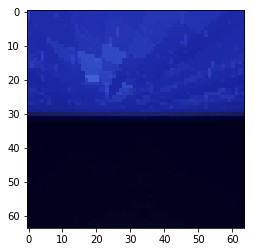

In [178]:
def train_model(target_model, q_model, n_epochs=200, tau = 20):
    tf.executing_eagerly()
    for epoch in range(n_epochs):
        print(epoch)
        simulate(target_model, q_model, epoch, tau)
        if epoch > 20:
            training_step(target_model, q_model, epoch, tau)
        if epoch % tau == 0:
            target_model.set_weights(q_model.get_weights())
        
train_model(target_model, q_model)

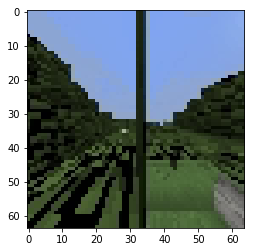

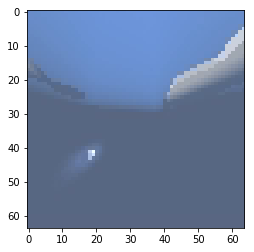

Guessed rewards:  [[  2.   4.  -1.  -2.   9.   3. -11. -15.  -9.  -9. -14.  -9. -17.]]
Target rewards:  [[ -0.   1.  -3.  -6.  -1.  -7.   4.   0.  -4. -12.  -5. -10.  -7.]]
Best predicted action:  4
Actions:  ['1' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1']


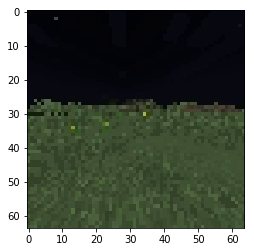

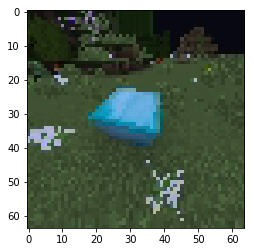

Guessed rewards:  [[ 17.  13.  22.   3.  11. -20.  18.   5.   8. -14.  -6. -12.  -5.]]
Target rewards:  [[-0.  2. 20. -4. -2. -3. -1.  4.  6. -5.  0.  5. -1.]]
Best predicted action:  2
Actions:  ['1' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1']


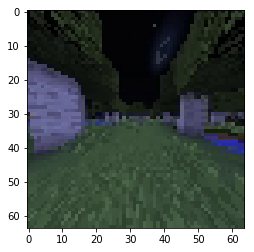

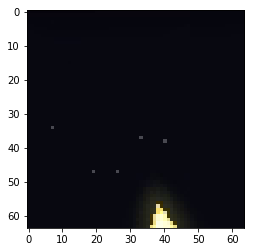

Guessed rewards:  [[-20.  12.  10. -14.  -4.   4.  -2.   6.  -9.  -1.  -5.  13.   0.]]
Target rewards:  [[ 2. 11. 28. -9. -6. -3. -2.  0.  5. -2. -4.  9.  4.]]
Best predicted action:  11
Actions:  ['1' '0' '0' '0' '1' '0' '1' '0' '0' '1' '0' '1' '0']


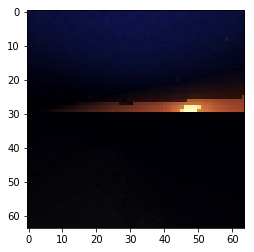

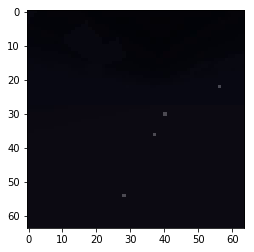

Guessed rewards:  [[ 6.  6. 18. -5. -0. -3.  2.  1.  4. -6. -6.  0. -3.]]
Target rewards:  [[  4. -13.  19.   2.   4. -17.   8.   2.   5. -12.   7.  -7.   0.]]
Best predicted action:  2
Actions:  ['1' '0' '0' '0' '1' '0' '0' '0' '0' '0' '0' '0' '0']


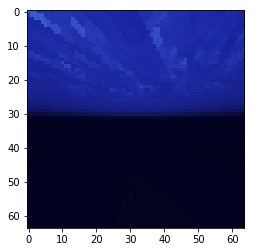

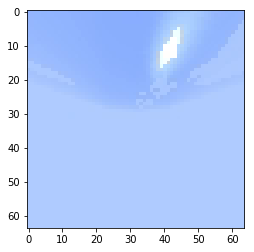

Guessed rewards:  [[ 10.  16.   5. -14.  15.  -9.  20. -28.  -9. -24. -20.  -4. -26.]]
Target rewards:  [[ -4.  10.   5.  -4.  -8. -27.  14. -27.  -6.  -1.  -6.  19.   4.]]
Best predicted action:  6
Actions:  ['1' '0' '0' '0' '1' '0' '1' '0' '0' '0' '0' '0' '0']


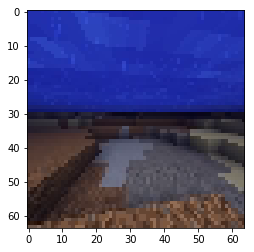

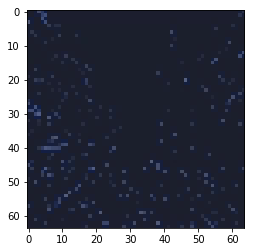

Guessed rewards:  [[ -5.  12.  26.  -4.   7. -11.   5.  -2.  -5.  -8. -25.   7.  -6.]]
Target rewards:  [[ -1.  -4.  11.   6.   1.  -2.   1. -17.   1. -37.   9.  -0.  25.]]
Best predicted action:  2
Actions:  ['1' '1' '0' '0' '0' '0' '1' '0' '0' '0' '1' '1' '0']


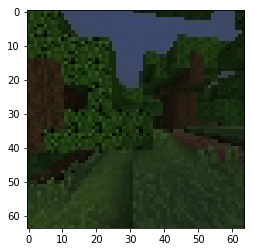

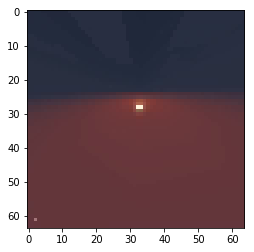

Guessed rewards:  [[ 13.  -4.  29.  -8.   1. -12.  -4.  -8.  -8. -12. -36.  -4. -15.]]
Target rewards:  [[  2.  -5.  15.   9. -16. -15.  -5.  15.   3.  12.  14.  12.  -2.]]
Best predicted action:  2
Actions:  ['1' '0' '0' '1' '1' '0' '1' '0' '0' '0' '0' '0' '0']


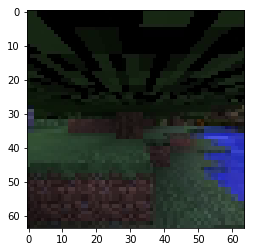

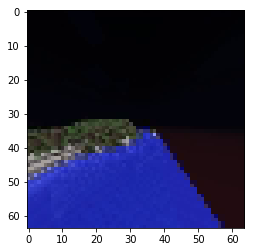

Guessed rewards:  [[  6. -16.  23.  -9. -13. -12.   2. -11.  -3.   1.   7.  13.  -3.]]
Target rewards:  [[  0. -20.  34. -11.  -4.  -3.   1. -13.   8.  -1. -13.   2.   8.]]
Best predicted action:  2
Actions:  ['1' '0' '0' '0' '1' '0' '1' '0' '0' '0' '0' '0' '0']


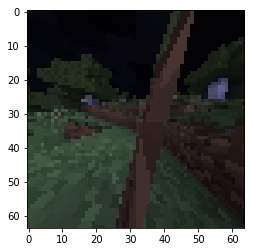

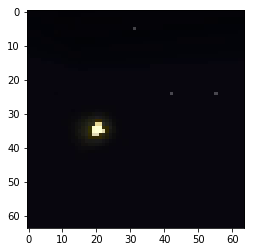

Guessed rewards:  [[ 18.  -3.  21.   4.  -8.  -8.   2.   3.  -6. -12.  -3.   3.   3.]]
Target rewards:  [[  5.  16.  16.  18.  -3.  -5.  -4.  -9.   7.  -3. -12.  19.  -3.]]
Best predicted action:  2
Actions:  ['1' '0' '0' '0' '0' '0' '0' '0' '0' '1' '0' '0' '1']


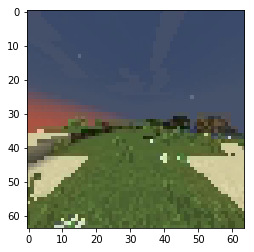

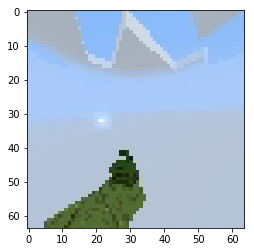

Guessed rewards:  [[ -2.  16.  11. -18.  21.  -3.  24.  -9.  11.  -7. -23.  15. -33.]]
Target rewards:  [[  0. -16.  19.  -2.   8. -20.   1. -18.  13.  -3. -17. -16.   8.]]
Best predicted action:  6
Actions:  ['1' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']


In [94]:
for i in range(10):    
    video, actions, compass_angle, rewards = generate_random_video(path)

    batch = np.random.randint(video.shape[0])
    frames = np.array(video[batch-4:batch])
    next_frames = np.array(video[batch-3:batch+1])

    plt.imshow(video[0].astype(np.uint8))
    plt.show()

    plt.imshow(video[-1].astype(np.uint8))
    plt.show()

    actions = np.array(actions[batch])
    frames = stack_frames(video, compass_angle[batch]).reshape(1, 64, 64, 5)
    n_frames = stack_frames(next_frames, compass_angle[batch+1]).reshape(1, 64, 64, 5)

    print("Guessed rewards: ", np.round(q_model(frames)))
    print("Target rewards: ", np.round(target_model(n_frames)))
    print("Best predicted action: ", np.argmax(q_model(frames)))
    print("Actions: ", actions)

In [149]:
target_model.save("target_q_model.h5")
q_model.save("q_model.h5")